<div class="alert alert-info" role="alert">
***
# Introduction
<p>
Twitter has become a prominent tool for political communication. During the 2016 elections twitter was used extensively by politicians to speak directly to their political opponents and the American people. All of the 100 US senators have an official verified twitter account (https://www.birdsonganalytics.com/blog/2017/02/21/full-list-of-us-senators-on-twitter-2017/). According to George Washington University all but 7 congresspersons have twitter accounts (https://gwu-libraries.github.io/sfm-ui/posts/2017-05-23-congress-seed-list).
Many news companies and websites have been dedicated to analyzing political tweets. The BBC published 7 articles and 5 TV segments involving Donald Trump’s tweets between June and September 2017. USA Today published an opinion article on July 10th, 2017 suggesting President Trump’s twitter account may be against the law. TweetCongress.org is a website that provides information about all the tweets issued by members of congress.  They also offer statistics about most followed and new followers for each congressperson. However, even with all of this monitoring and analysis of political tweets it is unclear if statements made via twitter are then translated into political action. 
    
This capstone project will analyze President Trump’s tweets.  Some of the questions I will try to answer are:
    <li>What does President Trump tweet about?</li>
    <li>Do his tweets translate into official actions of any kind?</li>
</p>    
***
</dvi>

In [87]:
# general imports
import pandas as pd
import numpy as np
from datetime import datetime
from collections import defaultdict
import pickle
# imports for webscraping and text manipulation
import requests
import re
import io
import urllib
# imports to convert pdf to text
from pdfminer.pdfinterp import PDFResourceManager, PDFPageInterpreter
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from pdfminer.pdfpage import PDFPage
# text cleaning imports
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
# imports for cosine similarity with NMF
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import normalize
from sklearn.feature_extraction import text
from collections import namedtuple
# imports for data visualization
import matplotlib.pyplot as plt
import seaborn as sns
# special matplotlib argument for in notebook improved plots
from matplotlib import rcParams
sns.set_style("whitegrid")
sns.set_context("poster")
# import for data exploration
nltk.download('stopwords')
from nltk.corpus import stopwords
import itertools
from collections import Counter
import seaborn as sns
plt.style.use('ggplot')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aregel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\aregel\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


***
# Part 1: Data Wrangle
#### Load and transform the data for analysis
<p>
    The first step in this analysis is to obtain and clean the data. The twitter data was obtained using the [Trump Twitter Archive](http://www.trumptwitterarchive.com/archive), the data is from 01/20/2017 - 03/02/2018 2:38 PM MST. I used the Federal Register's website to obtain all of the actions published by the Executive Office for the same time frame.
</p>

***

<div class="alert alert-info" role="alert">
    <H3> The data included in this repo has already been wrangled using the code in this section. The webscraping and pdf conversion takes a bit of time, so unless you need a different time frame I would suggest just using the included pickeled datasets </H3>


## Collect and Clean Twitter Data


#### Convert json data to pandas dataframe

In [11]:
# load json twitter data
twitter_json = r'data/twitter_01_20_17_to_3-2-18.json'
# Convert to pandas dataframe
tweet_data = pd.read_json(twitter_json)

#### Clean-up data types and identify hashtags and @mentions

In [13]:
# helper functions

# identify hash tags
def hash_tag(text):
    return re.findall(r'(#[^\s]+)', text) 
# identify @mentions
def at_tag(text):
    return re.findall(r'(@[A-Za-z_]+)[^s]', text)

In [14]:
# set column 'created_at' to the index
tweet_data.set_index('created_at', drop=True, inplace= True)
# convert timestamp index to a datetime index
pd.to_datetime(tweet_data.index)

DatetimeIndex(['2018-03-02 03:04:51', '2018-03-02 02:59:37',
               '2018-03-02 02:58:35', '2018-03-02 00:52:43',
               '2018-03-02 00:51:28', '2018-03-01 21:31:32',
               '2018-03-01 20:40:52', '2018-03-01 18:26:55',
               '2018-03-01 18:06:30', '2018-03-01 12:12:42',
               ...
               '2017-01-20 18:00:43', '2017-01-20 17:58:24',
               '2017-01-20 17:55:44', '2017-01-20 17:54:36',
               '2017-01-20 17:54:00', '2017-01-20 17:53:17',
               '2017-01-20 17:52:45', '2017-01-20 17:51:58',
               '2017-01-20 17:51:25', '2017-01-20 12:31:53'],
              dtype='datetime64[ns]', name='created_at', length=2792, freq=None)

In [15]:
# tokenize all the tweet's text
tweet_data['text_tokenized'] = tweet_data['text'].apply(lambda x: word_tokenize(x.lower()))
# apply hash tag function to text column
tweet_data['hash_tags'] = tweet_data['text'].apply(lambda x: hash_tag(x))
# apply at_tag function to text column
tweet_data['@_tags'] = tweet_data['text'].apply(lambda x: at_tag(x))

In [16]:
tweet_data.head()

,favorite_count,id_str,is_retweet,retweet_count,source,text,text_tokenized,hash_tags,@_tags
created_at,,,,,,,,,
2018-03-02 03:04:51,72306,969408165308747776,False,14304,Twitter for iPhone,Good (Great) meeting in the Oval Office tonigh...,"[good, (, great, ), meeting, in, the, oval, of...",[],[]
2018-03-02 02:59:37,0,969406846602752000,True,4612,Twitter for iPhone,RT @IvankaTrump: My OpEd on the importance of ...,"[rt, @, ivankatrump, :, my, oped, on, the, imp...",[#YouthSports],[@IvankaTrump]
2018-03-02 02:58:35,0,969406584534257664,True,7927,Twitter for iPhone,RT @Scavino45: â€œTrump Comes Through â€” Save...,"[rt, @, scavino45, :, â€œtrump, comes, through...",[],[@Scavino]
2018-03-02 00:52:43,60701,969374909209239552,False,12139,Twitter for iPhone,Manufacturing growing at the fastest pace in a...,"[manufacturing, growing, at, the, fastest, pac...",[],[]
2018-03-02 00:51:28,60380,969374597127778304,False,12339,Twitter for iPhone,Jobless claims at a 49 year low!,"[jobless, claims, at, a, 49, year, low, !]",[],[]


#### Save clean twitter data as pickle

In [7]:
# pickle data
tweet_pickle_path = r'data/twitter_01_20_17_to_3-2-18.pickle'
tweet_data.to_pickle(tweet_pickle_path)

#### Scrape and format Data from Federal Register

In [9]:
# Define the 2017 url that contains all of the Executive Office of the President's published documents
executive_office_url_2017 = r'https://www.federalregister.gov/index/2017/executive-office-of-the-president' 
executive_office_url_2018 = r'https://www.federalregister.gov/index/2018/executive-office-of-the-president' 
# scrape all urls for pdf documents published in 2017 and 2018 by the U.S.A. Executive Office
pdf_urls= []
for url in [executive_office_url_2017,executive_office_url_2018]:
    response = requests.get(url)
    pattern = re.compile(r'https:.*\.pdf')
    pdfs = re.findall(pattern, response.text)
    pdf_urls.append(pdfs)

In [10]:
# writes all of the pdfs to the data folder
start = 'data/'
end = '.pdf'
num = 0
for i in range(0,(len(pdf_urls))):
    for url in pdf_urls[i]:
        ver = str(num)
        pdf_path = start + ver + end
        r = requests.get(url)
        file = open(pdf_path, 'wb')
        file.write(r.content)
        file.close()
        num = num + 1

#### Create a dataframe with the published date and text for each pdf

In [2]:
# helper functions
# function to convert pdf to text from stack overflow (https://stackoverflow.com/questions/26494211/extracting-text-from-a-pdf-file-using-pdfminer-in-python/44476759#44476759)
def convert_pdf_to_txt(path):
    rsrcmgr = PDFResourceManager()
    retstr = io.StringIO()
    codec = 'utf-8'
    laparams = LAParams()
    device = TextConverter(rsrcmgr, retstr, codec=codec, laparams=laparams)
    fp = open(path, 'rb')
    interpreter = PDFPageInterpreter(rsrcmgr, device)
    password = ""
    maxpages = 0
    caching = True
    pagenos = set()

    for page in PDFPage.get_pages(fp, pagenos, maxpages=maxpages,
                                  password=password,
                                  caching=caching,
                                  check_extractable=True):
        interpreter.process_page(page)

    text = retstr.getvalue()

    fp.close()
    device.close()
    retstr.close()
    return text
# finds the first time the name of a day appears in the txt, and returns that name

def find_day(word_generator):
    day_list = ['Monday,', 'Tuesday,', 'Wednesday,', 'Thursday,', 'Friday,', 'Saturday,', 'Sunday,']
    day_name_dict = {'Mon':'Monday,', 'Tue':'Tuesday,','Wed':'Wednesday,','Thu':'Thursday,','Fri':'Friday,','Sat':'Saturday,','Sun':'Sunday,'}
    day_name = []
    for val in word_generator:
        if val in day_list:
            num_position = txt.index(val)
            day_name.append(txt[num_position] + txt[num_position + 1] + txt[num_position +2])
            break
            
    return day_name_dict[day_name[0]]
# takes text and returns the first date in the document
def extract_date(txt):
    word_generator = (word for word in txt.split())
    day_name = find_day(word_generator)
    txt_start = int(txt.index(day_name))
    txt_end = txt_start + 40
    date_txt = txt[txt_start:txt_end].replace('\n','')
    cleaned_txt = re.findall('.* \d{4}', date_txt)
    date_list = cleaned_txt[0].split()
    clean_date_list = map(lambda x:x.strip(","), date_list)
    clean_date_string = ", ".join(clean_date_list)
    date_obj = datetime.strptime(clean_date_string, '%A, %B, %d, %Y')
    return date_obj


In [3]:
# create dictionary where: publication date = key, text = value
start_path = r'data/'
end_path = '.pdf'
data_dict = defaultdict(list)
for i in range(0,312):
    file_path = start_path + str(i) + end_path
    txt = convert_pdf_to_txt(file_path)
    date_obj = extract_date(txt)
    data_dict[date_obj].append(txt)

In [4]:
# create list of tuples where: (date, text)
tuple_lst = []
for k, v in data_dict.items():
    if v != None:
        for text in v:
            tuple_lst.append((k, text))
    else:
        print(k)

In [5]:
# create dataframe from list of tuples
fed_reg_dataframe = pd.DataFrame.from_records(tuple_lst, columns=['date','str_text'], index = 'date')

In [6]:
# tokenize all the pdf text
fed_reg_dataframe['token_text'] = fed_reg_dataframe['str_text'].apply(lambda x: word_tokenize(x.lower()))

#### Save federal register data as a pickle file to use in later analysis

In [7]:
# final dataframe
final_df = fed_reg_dataframe[fed_reg_dataframe.index > '2017-01-20']
# pickle final data
fed_reg_data = r'data/fed_reg_data.pickle'
final_df.to_pickle(fed_reg_data)

***
# Part 2: Explore the Data

1. Determine the most used hashtags
2. Determine who President Trump tweeted at(@) the most
3. Create a word frequency plot for the most used words in the twitter data and the presidental documents
4. Find words that both data sets have in common, and determine those words document frequency (what percentage of documents those words appear in)
***

In [2]:
# load federal document data from pickle file
fed_reg_data = r'data/fed_reg_data.pickle'
fed_data = pd.read_pickle(fed_reg_data)
# load twitter data from csv
twitter_file_path = r'data/twitter_01_20_17_to_3-2-18.pickle'
twitter_data = pd.read_pickle(twitter_file_path)

In [3]:
# find the most used hashtags
hashtag_freq = Counter(list(itertools.chain(*(twitter_data.hash_tags))))
hashtag_top20 = hashtag_freq.most_common(20)
# find the most used @ tags
at_tag_freq = Counter(list(itertools.chain(*(twitter_data['@_tags']))))
at_tags_top20 = at_tag_freq.most_common(20)

#### Most used hastags

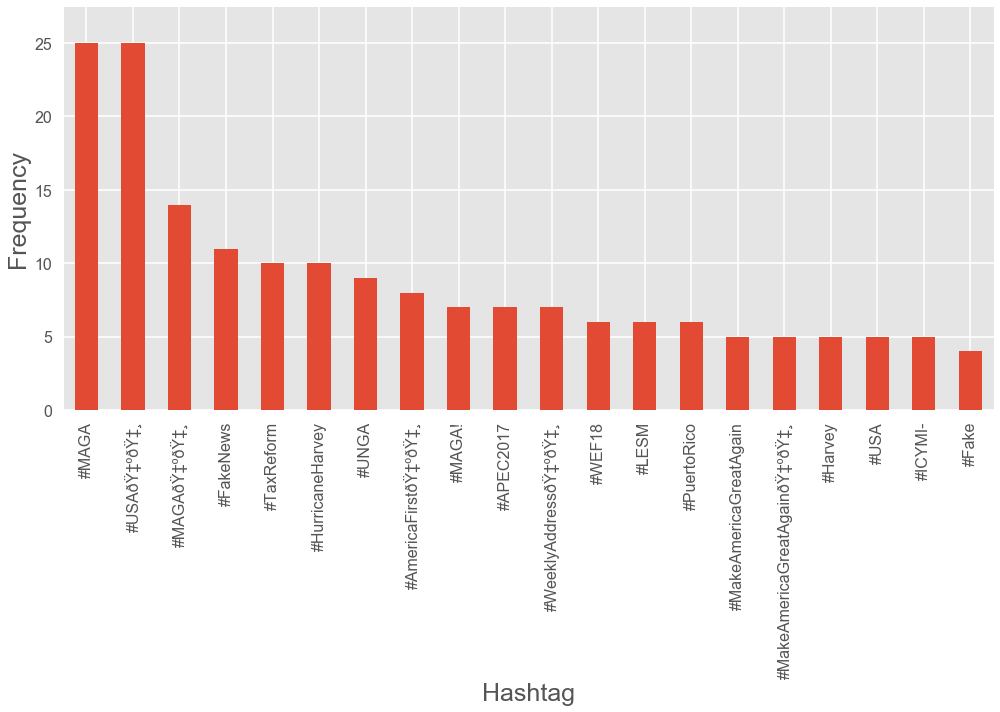

In [4]:
# frequency plot for the most used hashtags
df = pd.DataFrame(hashtag_top20, columns=['Hashtag', 'frequency'])
ax = df.plot(kind='bar', x='Hashtag',legend=None,figsize=(14,10))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
#plt.xticks(rotation=45)
plt.ylabel('Frequency', fontsize=25)
plt.xlabel('Hashtag', fontsize=25)
plt.tight_layout()
ax.set_ylim([0,27.5])
plt.show()

#### Most used @tags

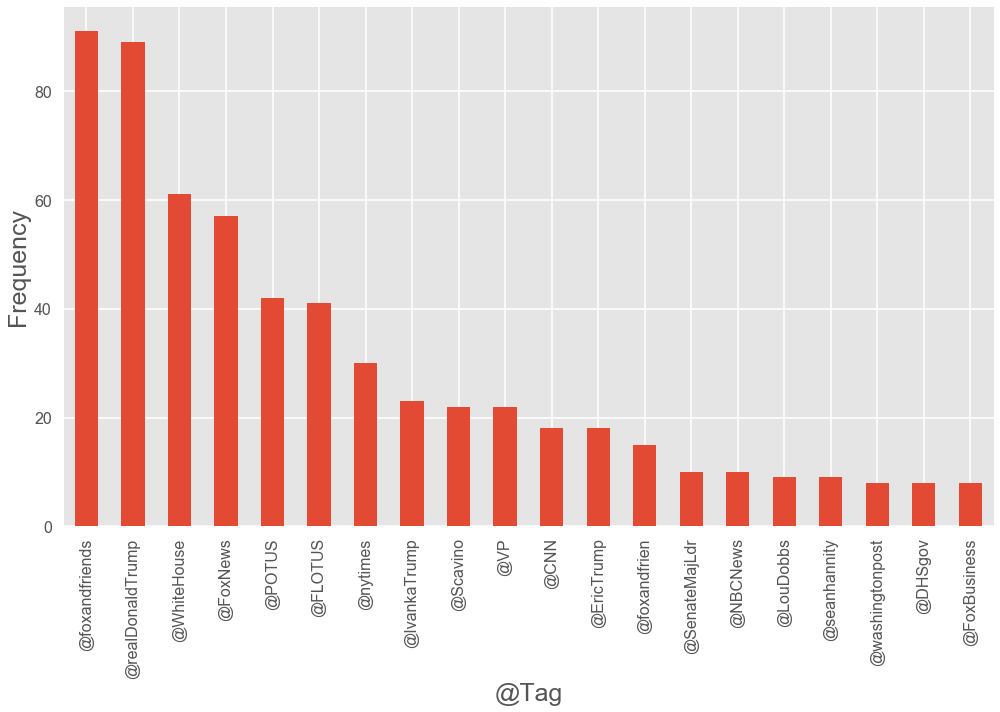

In [5]:
# frequency plot for the most used @ tags
df = pd.DataFrame(at_tags_top20, columns=['@ Tag', 'frequency'])
ax = df.plot(kind='bar', x='@ Tag',legend=None, figsize=(14,10))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
#plt.xticks(rotation=45)
plt.ylabel('Frequency', fontsize=25)
plt.xlabel('@Tag', fontsize=25)
plt.tight_layout()
plt.show()

#### Top used words for the twitter data and the federal document data

In [6]:
# use nltk's list of stopwords
stop_words = set(stopwords.words('english'))
# add puncuation to stopwords
stop_words.update(['.', ',','get','going','one', 'amp','like' '"','...',"''", "'","n't", '?', '!', ':', ';', '#','@', '(', ')', 'https', '``',"'s", 'rt' ])
# combine the hashtags and @ tags, flatten the list of lists, keep the unique items
stop_twitter = set(list(itertools.chain(*(twitter_data.hash_tags + twitter_data['@_tags']))))
# stop words for federal documents
stop_fed_docs = ['united', 'states', '1','2','3','4','5','6','7','8','9','10', '11','12','13','14','15',
                 '16','17','18','19','20','21','22','23','24','25','26','27','28','29','30','31','2016', '2015','2014',
                 'federal','shall','1.','2.','3.', '4790', 'national', '2017', 'order','president', 'presidential', 'sep',
                 'register','po','verdate', 'jkt','00000','frm','fmt','sfmt','vol','section','donald',
                 'act','america', 'executive','secretary', 'law', 'proclamation','81','day','including', 'code', 
                 '4705','authority', 'agencies', '241001', 'americans','238001','year', 'amp',
                 'government','agency','hereby','people','public','person','state','american','two',
                 'nation', '82', 'sec', 'laws', 'policy','set','fr','appropriate','doc','new','filed',
                 'u.s.c','department','ii','also','office','country','within','memorandum', 'director', 'us', 
                 'sunday','monday', 'tuesday','wednesday','thursday', 'friday', 'saturday', 'title','upon',
                 'constitution','support', 'vested','part', 'month', 'subheading','foreign','general','january',
                 'february', 'march', 'april','may','june','july','august', 'september', 'october',
                 'november', 'december', 'council','provide','consistent','pursuant','thereof','00001','documents',
                 '11:15', 'area','management','following','house','white','week','therefore',
                 'amended', 'continue', 'chapter','must','years', '00002', 'use','make','date','one',
                 'many','12', 'commission','provisions', 'every','u.s.','functions','made','hand','necessary', 
                 'witness','time','otherwise', 'proclaim', 'follows','thousand', 'efforts','jan', 'trump','j.',
                 'applicable', '4717','whereof','hereunto', 'subject', 'report','3—', '3295–f7–p']

In [7]:
# helper functions
def remove_from_fed_data(token_lst):
    # remove stopwords and one letter words
    filtered_lst = [word for word in token_lst if word.lower() not in stop_fed_docs and len(word) > 1 and word.lower() not in stop_words]
    return filtered_lst 
def remove_from_twitter_data(token_lst):
    # remove stopwords and one letter words
    filtered_lst = [word for word in token_lst if word.lower() not in stop_words and len(word) > 1 and word.lower() not in stop_twitter]
    return filtered_lst 

In [8]:
# apply the remove_stopwords function to all of the tokenized twitter text
twitter_words = twitter_data.text_tokenized.apply(lambda x: remove_from_twitter_data(x))
# apply the remove_stopwords function to all of the tokenized document text
document_words = fed_data.token_text.apply(lambda x: remove_from_fed_data(x))

# flatten each the word lists into one list
all_twitter_words = list(itertools.chain(*twitter_words))
all_document_words =list(itertools.chain(*document_words))

In [9]:
# create a dictionary using the Counter method, where the key is a word and the value is the number of time it was used
twitter_freq = Counter(all_twitter_words)
doc_freq = Counter(all_document_words)
# determine the top 30 words used in the twitter data
top_30_tweet = twitter_freq.most_common(30)
top_30_fed = doc_freq.most_common(30)

#### Frequency plots for most used words in the federal data and twitter data

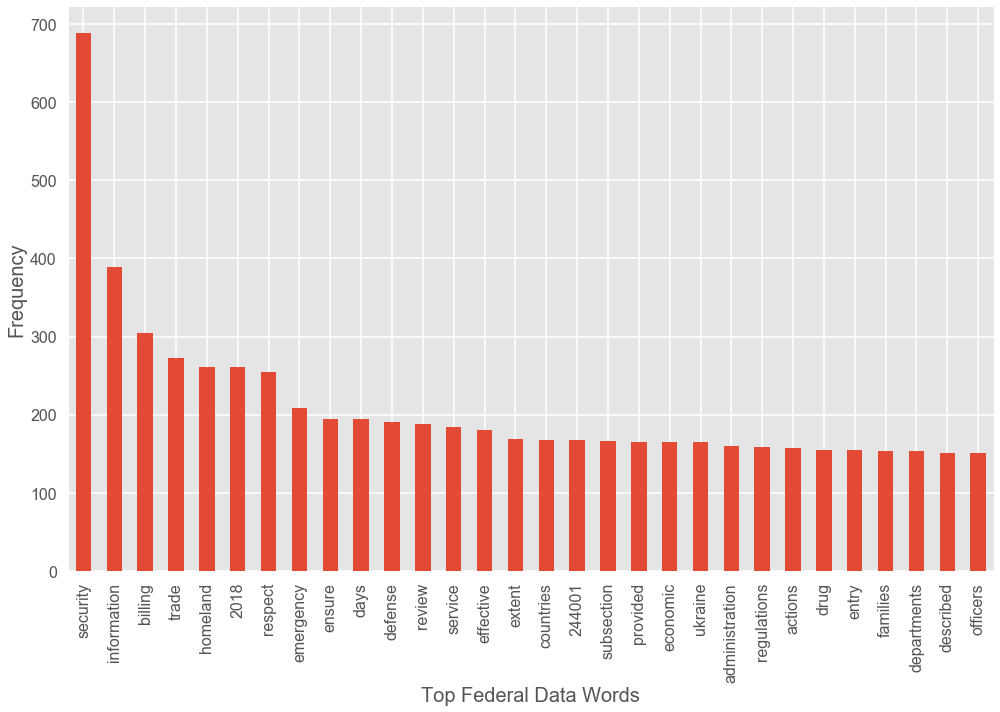

In [10]:
# frequency plot for the most used Federal Data
df = pd.DataFrame(top_30_fed, columns=['Federal Data', 'frequency'])
ax = df.plot(kind='bar', x='Federal Data',legend=None, figsize=(14,10))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Top Federal Data Words', fontsize=20)
plt.tight_layout()
plt.show()

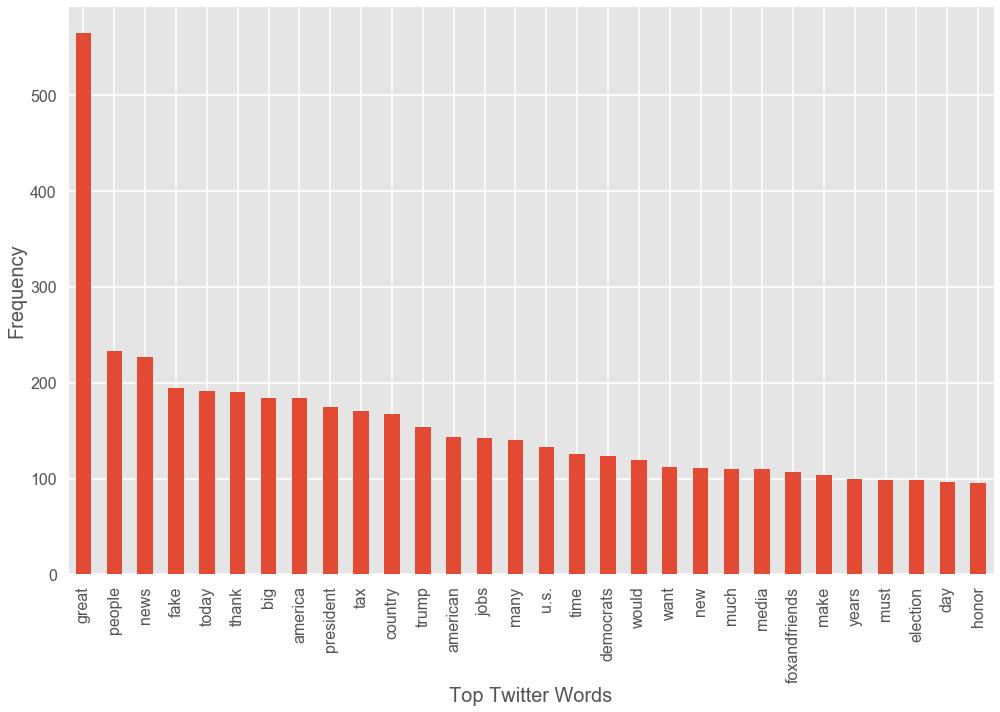

In [69]:
# frequency plot for the most used words in the twitter data
df = pd.DataFrame(top_30_tweet, columns=['Twitter Data', 'frequency'])
ax = df.plot(kind='bar', x='Twitter Data',legend=None, figsize=(14,10))
plt.ylabel('Frequency')
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Top Twitter Words', fontsize=20)
plt.tight_layout()
plt.show()

In [17]:
# find the unique words in each dataset
joint_words = list((set(all_document_words)).intersection(all_twitter_words))
# make array of zeros
values = np.zeros(len(joint_words))
# create dictionary
joint_words_dict = dict(zip(joint_words, values))
# create a dictionary with a word as key, and a value = number of documents that contain the word for Twitter
twitter_document_freq = joint_words_dict.copy()
for word in joint_words:
    for lst in twitter_data.text_tokenized:
        if word in lst:
            twitter_document_freq[word]= twitter_document_freq[word] + 1
            
# create a dictionary with a word as key, and a value = number of documents that contain the word for Fed Data
fed_document_freq = joint_words_dict.copy()
for word in joint_words:
    for lst in fed_data.token_text:
        if word in lst:
            fed_document_freq[word]= fed_document_freq[word] + 1
df = pd.DataFrame([fed_document_freq, twitter_document_freq]).T
df.columns = ['Fed', 'Tweet']
df['% Fed'] = (df.Fed/len(df.Fed))*100
df['% Tweet'] = (df.Tweet/len(df.Tweet))*100
top_joint_fed = df[['% Fed','% Tweet']].sort_values(by='% Fed', ascending=False)[0:30] 
top_joint_tweet = df[['% Fed','% Tweet']].sort_values(by='% Tweet', ascending=False)[0:30] 

In [18]:
top_joint_fed = df[['% Fed','% Tweet']].sort_values(by='% Fed', ascending=False)[0:30] 
top_joint_tweet = df[['% Fed','% Tweet']].sort_values(by='% Tweet', ascending=False)[0:30] 

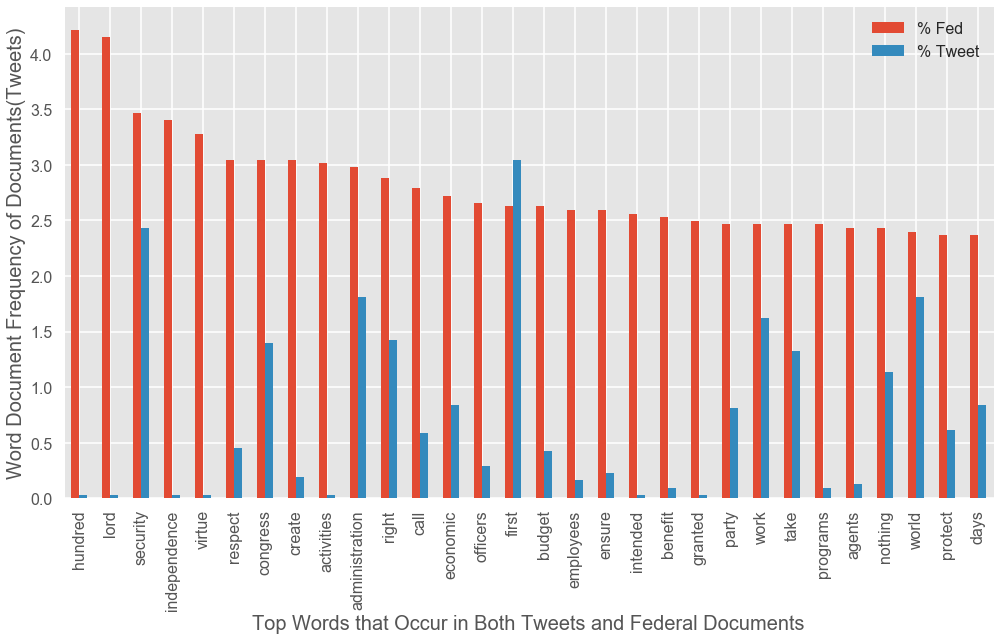

In [36]:
# plot the top words used in the fedaral data that are also in tweets
ax = top_joint_fed.plot.bar(figsize=(14,9))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
plt.ylabel('Word Document Frequency of Documents(Tweets)', fontsize=20)
plt.xlabel('Top Words that Occur in Both Tweets and Federal Documents', fontsize=20)
plt.tight_layout()
plt.show()

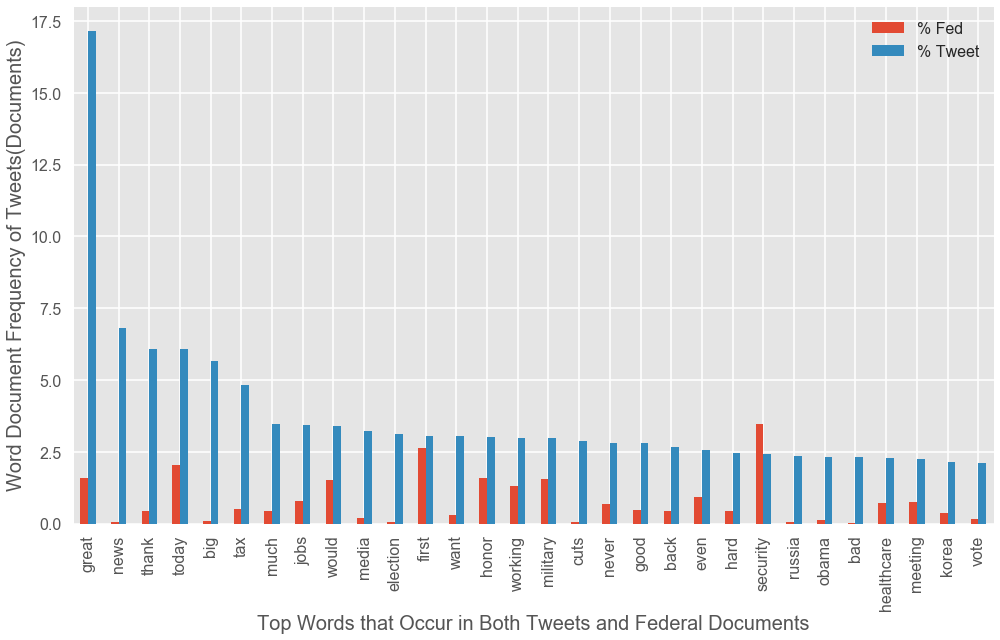

In [38]:
# plot the top words used in tweets that are also in federal data
ax = top_joint_tweet.plot.bar(figsize=(14,9))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
plt.ylabel('Word Document Frequency of Tweets(Documents)', fontsize=20)
plt.xlabel('Top Words that Occur in Both Tweets and Federal Documents', fontsize=20)
plt.tight_layout()

plt.show()

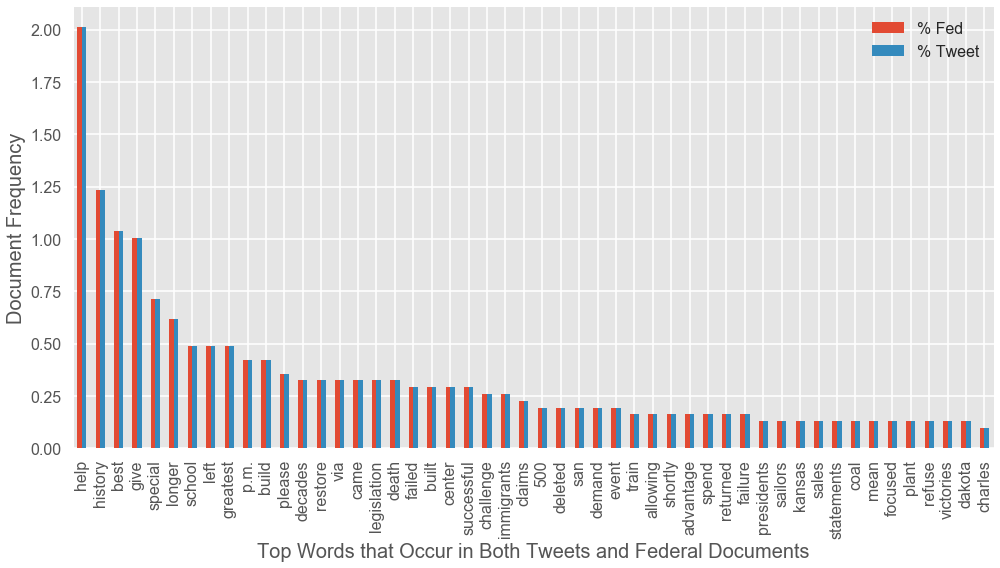

In [40]:
# plot the words that are used with the same frequency in both the twitter and federal data
df['diff %'] = df['% Fed'] - df['% Tweet']
top_same = df[df['diff %'] == 0].sort_values(by='% Fed', ascending=False)[0:50]
ax = top_same[['% Fed', '% Tweet']].plot.bar(figsize=(14,8))
# change tick markes
plt.tick_params(top='off', bottom = 'on', left = 'on', right = 'off', labelleft = 'on', labelbottom = 'on')
plt.ylabel('Document Frequency', fontsize=20)
plt.xlabel('Top Words that Occur in Both Tweets and Federal Documents', fontsize=20)
plt.tight_layout()
plt.show()

## Part 2 conclusions:
<p>
    The informal and non-regular grammar used in tweets makes a direct comparison with documents published by the Executive Office, which uses formal vocabulary and grammar, difficult. Thus, I will use two different methods to analyze the data, topic determination with non-zero matrix factorization (NMF) and document similarity using cosine similarity. The cosine similarity metric compares the distance between document vectors, instead of direct word comparison. Higher cosine similarities between two documents indicate greater topic similarity.
</p>


***
# Part 3: Analyze Twitter and Federal Data using NMF and Cosine Similarity
***

#### Part 3A: Transform data for analysis

In [42]:
# load federal document data from pickle file
fed_reg_data = r'data/fed_reg_data.pickle'
fed_data = pd.read_pickle(fed_reg_data)
# load twitter data from csv
twitter_file_path = r'data\twitter_01_20_17_to_3-2-18.pickle'
twitter_data = pd.read_pickle(twitter_file_path)
# Change the index (date), to a column
fed_data['date'] = fed_data.index
twitter_data['date'] = twitter_data.index
# keep text strings and rename columns
fed = fed_data[['str_text', 'date']].rename({'str_text': 'texts'}, axis = 'columns')
tweet = twitter_data[['text', 'date']].rename({'text': 'texts'}, axis = 'columns')

# Add a label for the type of document (Tweet = 0, Fed = 1)
tweet['label'] = 0
fed['label'] = 1

# concatinate the dataframes
comb_text = pd.concat([fed,tweet])

# Re_index so that each doc has a unique id_number
comb_text = comb_text.reset_index()
comb_text['ID'] = range(0,len(comb_text))

# Look at the dataframe to make sure it works
comb_text = comb_text[['texts','date','label', 'ID']]
comb_text.head(3)

,texts,date,label,ID
0,"Federal Register / Vol. 82, No. 161 / Tues...",2017-08-22,1,0
1,"Federal Register / Vol. 82, No. 188 / Frid...",2017-09-29,1,1
2,"42706 \n\nFederal Register / Vol. 82, No. ...",2017-09-11,1,2


#### Identify nonsense words for both twitter and federal data

In [43]:
# nonsense words, and standard words like proclimation and dates
more_stop = set(['presidential', 'documents', 'therfore','i','donald', 'j', 'trump', 'president', 'order', 
                 'authority', 'vested', 'articles','january','february','march','april','may','june','july','august','september','october',
                 'november','december','jan','feb','mar','apr','jun','jul','aug','sep','oct','nov','dec',
                 '2017','2018','act','agencies','agency','wh','rtlwanjjiq','pmgil08opp','blkgzkqemw','qcdljff3wn','erycjgj23r ','fzep1e9mo7','m0hmpbuz6c','rdo6jt2pip','kyv866prde','aql4jlvndh',
             'tx5snacaas','t0eigo6lp8','jntoth0mol','8b8aya7v1s', 'x25t9tqani','q7air0bum2','ypfvhtq8te','ejxevz3a1r','1zo6zc2pxt',
             'strciewuws','lhos4naagl','djlzvlq6tj', 'theplumlinegs', '3eyf3nir4b','cbewjsq1a3','lvmjz9ax0u',
             'dw0zkytyft','sybl47cszn','6sdcyiw4kt','¼ï','yqf6exhm7x','cored8rfl2','6xjxeg1gss','dbvwkddesd',
             'ncmsf4fqpr','twunktgbnb','ur0eetseno','ghqbca7yii','cbqrst4ln4','c3zikdtowc','6snvq0dzxn','ekfrktnvuy',
             'k2jakipfji','œthe ','p1fh8jmmfa','vhmv7qoutk','mkuhbegzqs','ajic3flnki','mvjbs44atr',
             'wakqmkdpxa','e0bup1k83z','ðÿ','ºðÿ','µðÿ','eqmwv1xbim','hlz48rlkif','td0rycwn8c','vs4mnwxtei','75wozgjqop',
             'e1q36nkt8g','u8inojtf6d','rmq1a5bdon','5cvnmhnmuh','pdg7vqqv6m','s0s6xqrjsc','5cvnmhnmuh','wlxkoisstg',
             'tmndnpbj3m','dnzrzikxhd','4qckkpbtcr','x8psdeb2ur','fejgjt4xp9','evxfqavnfs','aty8r3kns2','pdg7vqqv6m','nqhi7xopmw',
             'lhos4naagl','32tfova4ov','zkyoioor62','np7kyhglsv','km0zoaulyh','kwvmqvelri','pirhr7layt',
             'v3aoj9ruh4','https','cg4dzhhbrv','qojom54gy8','75wozgjqop','aty8r3kns2','nxrwer1gez','rvxcpafi2a','vb0ao3s18d',
             'qggwewuvek','ddi1ywi7yz','r5nxc9ooa4','6lt9mlaj86','1jb53segv4','vhmv7qoutk','i7h4ryin3h',
             'aql4jlvndh','yfv0wijgby','nonhjywp4j','zomixteljq','iqum1rfqso','2nl6slwnmh','qejlzzgjdk',
             'p3crvve0cy','s0s6xqrjsc','gkockgndtc','2nl6slwnmh','zkyoioor62','clolxte3d4','iqum1rfqso',
             'msala9poat','p1f12i9gvt','mit2lj7q90','qejlzzgjdk','pjldxy3hd9','vjzkgtyqb9','b2nqzj53ft',
             'tpz7eqjluh','enyxyeqgcp','avlrroxmm4','2kuqfkqbsx','kwvmqvelri','œi','9lxx1iqo7m','vdtiyl0ua7',
             'dmhl7xieqv','3jbddn8ymj','gysxxqazbl','ðÿž','tx5snacaas','4igwdl4kia','kqdbvxpekk','1avysamed4',
             'cr4i8dvunc','bsp5f3pgbz','rlwst30gud','rlwst30gud','g4elhh9joh', '2017', 'January', 'kuqizdz4ra', 
             'nvdvrrwls4','ymuqsvvtsb', 'rgdu9plvfk','bk7sdv9phu','b5qbn6llze','xgoqphywrt ','hscs4y9zjk ',
             'soamdxxta8','erycjgj23r','ryyp51mxdq','gttk3vjmku','j882zbyvkj','9pfqnrsh1z','ubbsfohmm7',
             'xshsynkvup','xwofp9z9ir','1iw7tvvnch','qeeknfuhue','riqeibnwk2','seavqk5zy5','7ef6ac6kec',
             'htjhrznqkj','8vsfl9mzxx','xgoqphywrt','zd0fkfvhvx','apvbu2b0jd','mstwl628xe','4hnxkr3ehw','mjij7hg3eu',
             '1majwrga3d','x6fuuxxyxe','6eqfmrzrnv','h1zi5xrkeo','kju0moxchk','trux3wzr3u','suanjs6ccz',
             'ecf5p4hjfz','m5ur4vv6uh','8j7y900vgk','7ef6ac6kec','d0aowhoh4x','aqqzmt10x7','zauqz4jfwv',
             'bmvjz1iv2a','gtowswxinv','1w3lvkpese','8n4abo9ihp','f6jo60i0ul','od7l8vpgjq','odlz2ndrta',
             '9tszrcc83j','6ocn9jfmag','qyt4bchvur','wkqhymcya3','tp4bkvtobq','baqzda3s2e','March','April',
             'op2xdzxvnc','d7es6ie4fy','proclamation','hcq9kmkc4e','rf9aivvb7g','sutyxbzer9','s0t3ctqc40','aw0av82xde'])
# defines all stop words
my_stop = text.ENGLISH_STOP_WORDS.union(more_stop)

#### Part 3B: Create a matrix representation of the text

<p> Computers cannot understand a text like humans, so in order to analyze text data, I first need to make every word a feature (column) in an array, where each document (row) is represented by a weighted* frequency of each word (column) they contain. An example text and array are shown below.
</p>

<p> Using Scikit Learn to create a word-frequency array:
<ul>
    <li> Define list of stop words (nonsense or non-meaninful words, such as 'the', 'a', 'of', 'q34fqwer3'). </li>
    <li> Instantiate a tf-idf object (term frequency-inverse document frequency reweighting), that removes the stop words, and filters any word that appears in 99% of the documents</li>
    <li> Create a matrix representation of the documents </li>
    <li> Create list of the words each feature(column) represents </li>
 </ul>
</p>

*Weighting the word frequencies lowers the importance of very frequently used, domain-specific, words

In [45]:
# Instantiate TfidfVectorizer to remove common english words, and any word used in 99% of the documents
tfidf = TfidfVectorizer(stop_words = my_stop , max_df = 0.99)
# create matrix representation of all documents
text_mat = tfidf.fit_transform(comb_text.texts)
# make a list of feature words
words = tfidf.get_feature_names()

#### Topic analysis using NMF
<p> Deconstruct the text matrix with non-zero matrix factorization (NMF) into discreet components:
<ul>
    <li> Instantiate NMF model with 200 components and initialized with Nonnegative Double Singular Value Decomposition (NNDSVD, better for sparseness)</li>
    <li> Fit(learn the NMF model for the tf-idf matrix) model</li>
    <li> Transform the model, which applies the fit to the matirix </li>
    <li> Make a dataframe with the NMF components for each word </li>
</ul>
</p>

In [131]:
# instantiate model
NMF_model = NMF(n_components=200 , init = 'nndsvd')
# fit the model
NMF_model.fit(text_mat)
# transform the text frequecy matrix using the fitted NMF model
nmf_features = NMF_model.transform(text_mat)
# create a dataframe with words as a columns, NMF components as rows
components_df = pd.DataFrame(NMF_model.components_, columns = words)

#### Find the top 5 topic words for each component
<p> Using the components dataframe create a dictionary with components as keys, and top words as values:
<ul>
    <li> Make an empty dictionary and loop through each row of NMF components</li>
    <li> Add to the dictionary where the key is the NMF component and the value is the topic words for that component (the column names with the largest component values)</li>

</ul>
</p>

In [132]:
# create dictionary with the key = component, value = top 5 words
topic_dict = {}
for i in range(0,160):
    component = components_df.iloc[i, :]
    topic_dict[i] = component.nlargest()

In [133]:
# look at a few of the component topics
print(topic_dict[124].index)
print(topic_dict[10].index)

Index(['10', '00', '20', '90', 'section'], dtype='object')
Index(['america', 'americafirstðÿ', 'encourages', 'prosperity', 'grow'], dtype='object')


#### Results of part 3 A and B: 
<p> 
    Looking through the top words for each component, the top 5 words do seem to represent a topic.   
</p>

#### Part 3C: Cosine Similarity

<p> The informal and non-regular grammar used in tweets makes a direct comparison with documents published by the Executive Office, which uses formal vocabulary and grammar, difficult. Therefore, I will use the metric, cosine similarity, which compares the distance between feature vectors, instead of direct word comparison. Higher cosine similarities between two documents indicate greater topic similarity.
</p>

<p>Calculating cosine similarities of NMF features:
<ul>
    <li> Normalize NMF features </li>
    <li> Create dataframe where each row contains the normalized NMF features for a document and its ID number</li>
    <li> Look at each row(decomposed article) and calculate its cosine similarity to all other document's normalized NMF features </li>
    <li> Create a dictionary where the key is the document ID, and the value is a pandas series of the 5 most similar documents (including its self)</li>

In [134]:
# normalize previouly found nmf features
norm_features = normalize(nmf_features)
#dataframe of document's NMF features, where rows are documents and columns are NMF components
df_norms = pd.DataFrame(norm_features)
# initialize empty dictionary
similarity_dict= {}
# loop through each row of the df_norms dataframe
for i in range(len(norm_features)):
    # isolate one row, by ID number
    row = df_norms.loc[i]
    # calculate the top cosine similarities
    top_sim = (df_norms.dot(row)).nlargest()
    # append results to dictionary
    similarity_dict[i] = (top_sim.index, top_sim) 

***
# Part 4: Use the cosine similarity results to explore how (or if) President Trump's tweets and official actions correlate
***

#### Part 4A: Find Twitter documents that have at least one federal document in its top 5 cosine similarity scores (and vice versa)
<p>  Using the results of part 3C, find the types of documents are the most similar, then sum the labels (0=twitter, 1= federal document). If similar documents are a mix of tweets and federal documents, then the sum of their value will be either 1,2,3 or 4.
<ul>
    <li> Create a dataframe with the document ID number as the index and the document type label (tweet = 0, fed_doc = 1)</li>
    <li> Loop through each document in the dataframe and use the similarity dictionary to find the list of most similar document ID numbers and the sum of the similarity scores</li>
    <li> For each list of similar documents, sum the value of the document type labels. If the sum value is 1, 2, 3, or 4, that means there are both tweets and federal documents in the group</li>
 
</ul>

</p>

In [135]:
# dataframe with document ID and labels
doc_label_df = comb_text[['label', 'ID']].copy().set_index('ID')
# inialize list for the sum of all similar documents label
label_sums =[]
similarity_score_sum = []
# loop through all of the documents
for doc_num in doc_label_df.index:
    # sum the similarity scores
    similarity_sum = similarity_dict[doc_num][1].sum()
    similarity_score_sum.append(similarity_sum)
    
 
    #find the list of similar documents
    similar_doc_ID_list = list(similarity_dict[doc_num][0])    
    # loop through labels
    s_label = 0
    for ID_num in similar_doc_ID_list:
        # sum the label values for each similar document
        s_label = s_label + doc_label_df.loc[ID_num].label
        
    # append the sum of the labels for ONE document
    label_sums.append(s_label)
# add the similarity score sum to dataframe as separate column
doc_label_df['similarity_score_sum'] = similarity_score_sum

# add the similar document's summed label value to the dataframe as a separate column
doc_label_df['sum_of_labels'] = label_sums  

#### Part 4b: Group tweets that have similar federal documents (and vice versa)
<p>  Isolate documents with mixed types of similar documents and high similarity scores
<ul>
    <li> Filter dataframe to include only top_similar_label_sums with a value of 1, 2, 3, or 4</li>
    <li> Filter again to only include groups with high combinded similarity scores</li>
    <li> Remove any duplicate groups </li>
 
</ul>

</p>

In [136]:
# Filter dataframe for federal documents with similar tweets, and vice versa
df_filtered = doc_label_df[doc_label_df['sum_of_labels'] != 0][doc_label_df['sum_of_labels'] != 5].copy().reset_index()

# Look at the ones that have all top 5 documents with a cosine similarity score of 0.9 or above.  
#The sum of scores need to be 4.6 or higher
similar_score_min = 4.6
highly_similar = df_filtered[df_filtered.similarity_score_sum >= similar_score_min]

# create a list of all the group lists
doc_groups = []
for doc_id in highly_similar.ID:
    doc_groups.append(sorted(list(similarity_dict[doc_id][0])))

# make the interior lists tuples, then make a set of them
unique_groups = list(set([tuple(x) for x in doc_groups]))


C:\Users\aregel\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


#### Group Again
Many of the unique groups are only different by one document. Those groups are similar to each other and should be combined.

In [138]:
# make a list of groups that are similar
similar_groups = []
for num1 in range(len(unique_groups)):
    for num2 in range(len(unique_groups)):
        crossover_count = len((set(unique_groups[num1]) & set(unique_groups[num2])))
        if crossover_count == 4:
            lst = [num1, num2]
            lst.sort(key=int)
            if lst not in similar_groups:
                similar_groups.append(lst)
            

In [149]:
# create list of document ID's of similar documents
similar_docs = []
for group1, group2 in similar_groups:
    combo = list(set(unique_groups[group1]) & set(unique_groups[group2]))
    if combo not in similar_docs:
        similar_docs.append(combo)

In [150]:
similar_docs

[[1471, 111, 2997, 2991],
 [148, 972, 973, 822],
 [20, 4, 3013, 2487],
 [2584, 20, 4, 3013],
 [922, 195, 236, 230],
 [20, 243, 4, 3013],
 [178, 349, 222, 2714]]

***
# Part 5: Manually look at some documents.  Are they similar?
***

In [151]:
# print document IDs grouped together
print(comb_text.texts.loc[1471])

Iran just test-fired a Ballistic Missile capable of reaching Israel.They are also working with North Korea.Not much of an agreement we have!


In [152]:
print(comb_text.texts.loc[111])

Federal  Register 

Vol.  82,  No.  119 

Thursday,  June  22,  2017 

Title  3— 

The  President 

Presidential Documents

28391 

Presidential  Determination  No.  2017–06  of  May  17,  2017 

Presidential  Determination  Pursuant  to  Section  1245(d)(4)(B) 
and  (C)  of  the  National  Defense  Authorization  Act  for  Fiscal 
Year  2012 

Memorandum  for  the  Secretary  of  State[,]  the  Secretary  of  the  Treasury[, 
and]  the  Secretary  of  Energy 

By  the  authority  vested  in  me  as  President  by  the  Constitution  and  the 
laws  of  the  United  States,  after  carefully  considering  the  reports  submitted 
to  the  Congress  by  the  Energy  Information  Administration,  including  the 
report  submitted  April  11,  2017,  and  other  relevant  factors  such  as  global 
economic conditions, increased oil production by certain countries, the level 
of  spare  petroleum  production  capacity,  and  the  availability  of  strategic 
reserves, I determine, pursuan

In [153]:
print(comb_text.texts.loc[2991])

Iran was on its last legs and ready to collapse until the U.S. came along and gave it a life-line in the form of the Iran Deal: $150 billion


In [154]:
print(comb_text.texts.loc[2997])

Iran is rapidly taking over more and more of Iraq even after the U.S. has squandered three trillion dollars there. Obvious long ago!


# Conclusions:
<p>
    All of the documents in the first group are about Iran, including 3 tweets and 1 federal document. 
However, only 7 unique groups were generated using this method.
So although I did find tweets that are similar to official action taken by the president, I don't think there is enough evidence to support the theory that tweets are an indicator of official action.
    </p>
    